Useful links:
- https://medium.com/data-science/data-augmentation-compilation-with-python-and-opencv-b76b1cd500e0
- https://docs.opencv.org/4.x/d3/dc1/tutorial_basic_linear_transform.html
- https://opencv.org/blog/color-spaces-in-opencv/#h-hsv-hue-saturation-value-color-space
- https://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42 # for testability purposes
keras.utils.set_random_seed(seed)
np.random.seed(seed)

C:\Users\Manuel\AppData\Roaming\Python\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [7]:
def color_jittering(img, brightness_range=(-60, 60), saturation_range=(-60, 60)):
    rng = np.random.default_rng()
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    brightness = rng.integers(brightness_range[0], brightness_range[1])
    saturation = rng.integers(saturation_range[0], saturation_range[1])

    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] + saturation, 0, 255)
    img_hsv[:, :, 2] = np.clip(img_hsv[:, :, 2] + brightness, 0, 255)

    img_hsv = img_hsv.astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

def contrast_stretching(img, linear_contrast=True, gamma_correction=False, gamma_correction_parameter=1.0):
    img_copy = img.copy()
    
    if linear_contrast:
        p_min = np.percentile(img_copy, 5)
        p_max = np.percentile(img_copy, 95)

        img_copy = np.clip((255/(p_max - p_min)) * (img_copy - p_min), 0, 255).astype(np.uint8)

    if gamma_correction:
        img_copy = np.clip(255 * np.power(img_copy/255, gamma_correction_parameter), 0, 255).astype(np.uint8)

    return img_copy

def cutout(img, size=64, color=50):
    rng = np.random.default_rng()
    img_copy = img.copy()

    x = rng.integers(0, img.shape[0] - size)
    y = rng.integers(0, img.shape[1] - size)

    img_copy[x : x + size, y : y + size] = color
    return img_copy

In [8]:
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

# maybe need a center crop?
def get_random_crop(img, cropX=224, cropY=224):
    max_x = img.shape[0] - cropX
    max_y = img.shape[1] - cropY

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[x: x + cropX, y: y + cropY]
    
    return crop

def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim) # is it fine even for val and test?
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [9]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train, X_train_original = load_data(url_directory, "train.txt", random_crop=True, return_original=True)
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [10]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
#labels_coarse

#### DATA AUGMENTATION

In [33]:
# DATA AUGMENTATION
X_train_augmented = []
y_train_augmented = []
n_crop = 1
rng = np.random.default_rng()

for idx, img in enumerate(X_train_original):
    lbl = y_train[idx]
    #print(f"shape original: {img.shape}")

    img_base = get_random_crop(img)
    X_train_augmented.append(img_base)
    y_train_augmented.append(lbl)
    #print(f"shape base: {img_base.shape}")

    if rng.integers(2) == 0: 
        img_base_flip = cv2.flip(img_base, 1)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)
    else:
        img_base_flip = cv2.flip(img_base, 0)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)

    #img_base_flip_both = cv2.flip(img_base, -1)
    #X_train_augmented.append(img_base_flip_both)
    #y_train_augmented.append(lbl)

    #if rng.integers(2) == 0:
    img_base_cutout = cutout(img_base_flip)
    X_train_augmented.append(img_base_cutout)
    y_train_augmented.append(lbl)

    for j in range(0, n_crop):
        img_new = get_random_crop(img)
        img_new = contrast_stretching(img_new)
        img_new = color_jittering(img_new)
        X_train_augmented.append(img_new)
        y_train_augmented.append(lbl)
        #print(f"shape new: {img_new.shape}")

        if rng.integers(2) == 0:
            img_new_flip = cv2.flip(img_new, 1) # here we are using the same image, maybe we can have different crop, color jittering etc...
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)
        else:
            img_new_flip = cv2.flip(img_new, 0) # same comment as before
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)

        #if rng.integers(2) == 0:
        img_new_cutout = cutout(img_new_flip)
        X_train_augmented.append(img_new_cutout)
        y_train_augmented.append(lbl)

        #img_new_flip_both = cv2.flip(img_new, -1) # same comment as before
        #X_train_augmented.append(img_new_flip_both)
        #y_train_augmented.append(lbl)
    #print("\n\n")

X_train_augmented = np.stack(X_train_augmented, axis=0)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

(15840, 224, 224, 3) (15840,)


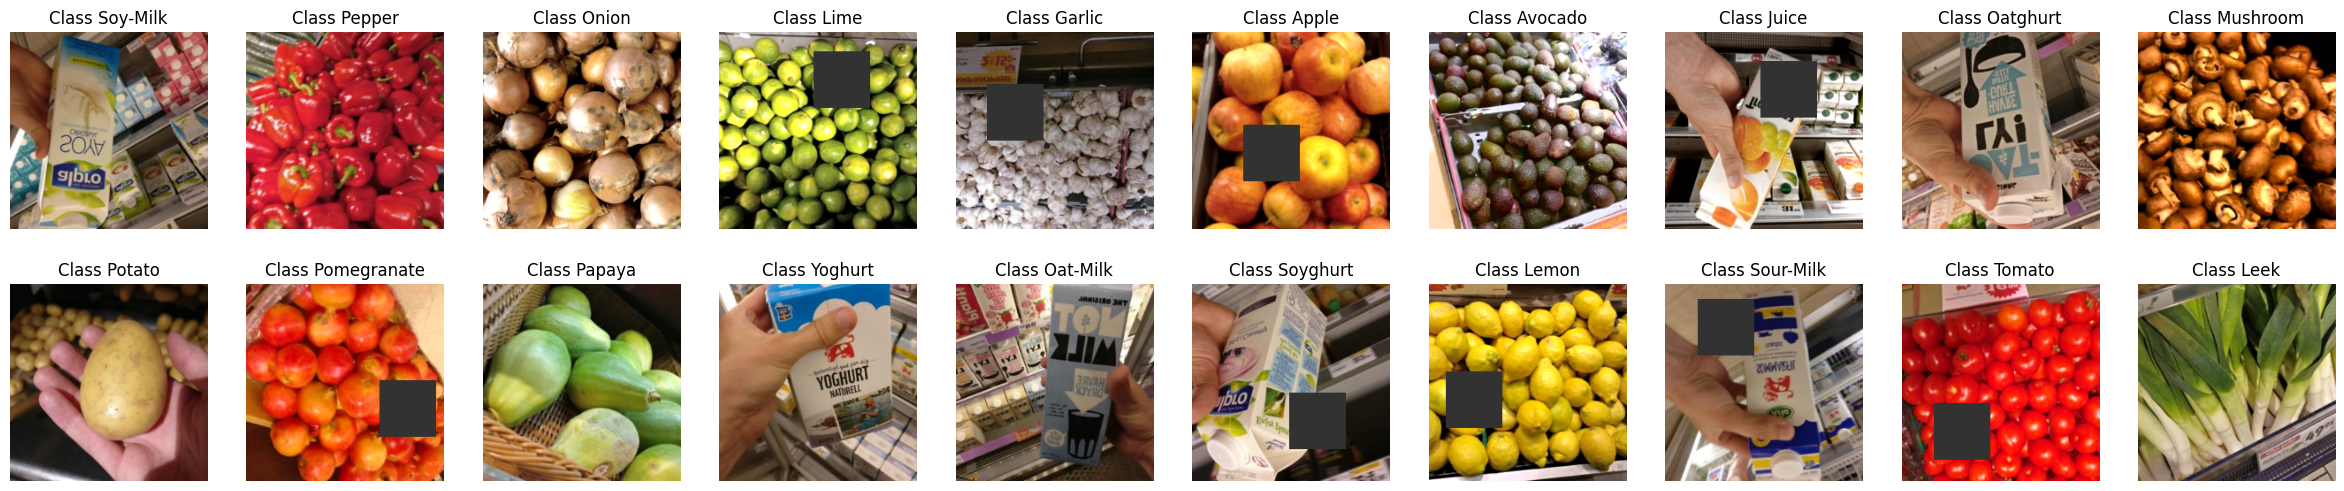

In [12]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train_augmented.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train_augmented[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train_augmented[rand_idx], cv2.COLOR_BGR2RGB))

#### DATA NORMALISATION

In [13]:
#X_train_augmented = X_train_augmented.astype(np.float32)
#X_train_augmented /= 255.0
#X_val = X_val.astype(np.uint8) / 255.0
#X_test = X_test.astype(np.uint8) / 255.0

# PROBLEM !! -> not enough RAM (look at ImageDataGenerator)

#print(f"The new range of the images is [{X_temp.min()},{X_temp.max()}].")
#X_train_augmented

#### MODEL BUILDING

In [36]:
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Rescaling

input_shape = X_train_augmented.shape[1:]

model = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_11 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │       8,630,315 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,649,707 (33.00 MB)

 Trainable params: 8,649,707 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

#### MODEL TRAINING

In [37]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 8
#val_split_percentage = 0.25

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 145s 291ms/step - accuracy: 0.5126 - loss: 1.7769 - val_accuracy: 0.3277 - val_loss: 2.4801
Epoch 2/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 145s 293ms/step - accuracy: 0.8912 - loss: 0.3582 - val_accuracy: 0.3649 - val_loss: 3.3937
Epoch 3/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 200s 290ms/step - accuracy: 0.9769 - loss: 0.0862 - val_accuracy: 0.3649 - val_loss: 4.0959
Epoch 4/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 147s 297ms/step - accuracy: 0.9895 - loss: 0.0420 - val_accuracy: 0.3176 - val_loss: 4.8849
Epoch 5/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 147s 297ms/step - accuracy: 0.9940 - loss: 0.0237 - val_accuracy: 0.3547 - val_loss: 4.3887
Epoch 6/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 142s 286ms/step - accuracy: 0.9991 - loss: 0.0051 - val_accuracy: 0.3682 - val_loss: 5.4124
Epoch 7/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 142s 286ms/step - accuracy: 0.9866 - loss: 0.0471 - val_accuracy: 0.2669 - val_loss: 5.2538
Epoch 8/8
495/495 ━━━━━━━━━━━━━━━━━━━━ 143s 290ms/step - accuracy: 0.9878 - loss: 0

#### MODEL EVALUATION

78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.4483 - loss: 3.9119
The test loss is 3.9119, the test accuracy is 0.4483.


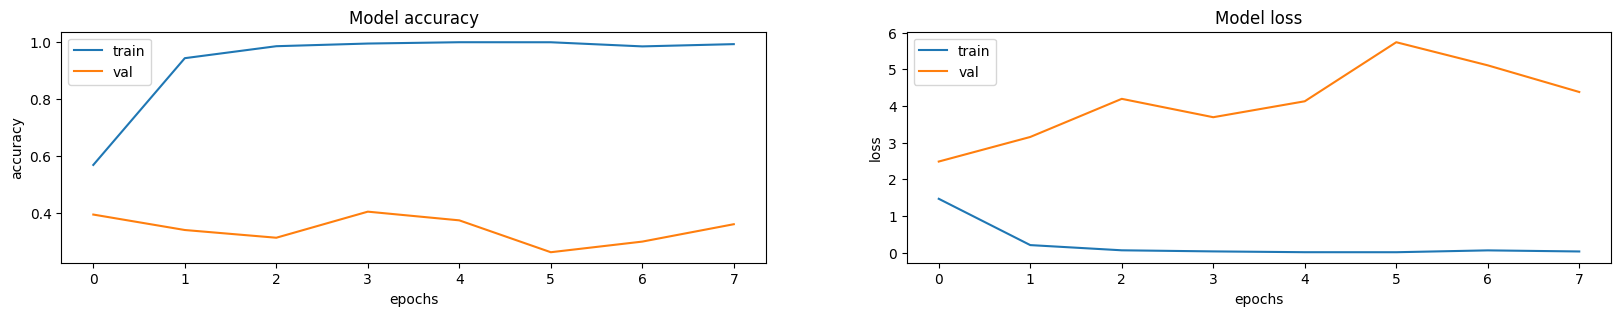

In [11]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model.history.history[metric])
    plt.plot(model.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = model.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

In [12]:
val_loss, val_metric = model.evaluate(X_val, y_val, verbose = 1)
print(f"The test loss is {val_loss:.4f}, the test accuracy is {val_metric:.4f}.")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.3615 - loss: 4.3779
The test loss is 4.3779, the test accuracy is 0.3615.
